In [1]:
using AdvancedHMC
using Cubature
using Distributions
using ForwardDiff
using LinearAlgebra
using NearestNeighbors
using Plots
using Random
using QuadGK

In [2]:
Random.seed!(500);

# Data generation

In [3]:
function effective_sample_size(weights)
    return (sum(weights))^2/sum(weights.^2)
end


effective_sample_size (generic function with 1 method)

In [4]:
function run_abc_round(; data = [0],
        simulator = x->x,
        proposal::Distribution = Product([Uniform(0,1)]), # product so outputs are vectors
        prior::Distribution = Product([Uniform(0,1)]),
        distance_function = (x,y) -> norm(x - y),
        epsilon = 1,
        target_acceptances = 800)
    # Runs one round of ABC until the number of accepted particles reaches target_acceptances
    num_proposals = 0
    parameter_example = rand(prior)
    particles = typeof(parameter_example)[]
    weights = Float64[]
    distances = Float64[]
    while length(particles) < target_acceptances
        num_proposals = num_proposals + 1
        new_particle = rand(proposal)
        simulated_data = simulator(new_particle)
        d = distance_function(data, simulated_data)
        if d < epsilon
            append!(particles, [new_particle])
            append!(weights, pdf(prior, new_particle)/pdf(proposal, new_particle))
            append!(distances, d)
        end
    end
    particles = hcat(particles...)
    
    return particles, weights, distances, num_proposals
end

run_abc_round (generic function with 1 method)

In [5]:
function run_smc(; data = [0],
        simulator = x -> x,
        prior::Distribution = Product([Uniform(0,1)]),
        distance_function = (x, y) -> norm(x - y),
        epsilon_schedule = [160, 120, 80, 60, 40, 30, 20, 15, 10, 8, 6, 4, 3, 2, 1], # taken from Filippi et al. kernel optimality
        target_acceptances = 800, # target acceptances each round
        proposal_function = make_proposal,
        proposal_kernel = :local_MVNormal,
    )
    
    num_proposals = zeros(length(epsilon_schedule))
    all_particles = []
    all_weights = []
    all_distances = []
    current_particles, current_weights, current_distances, num_proposals[1] = run_abc_round(data = data,
                                                                         simulator = simulator,
                                                                         proposal = prior,
                                                                         prior = prior,
                                                                         distance_function = distance_function,
                                                                         epsilon = epsilon_schedule[1],
                                                                         target_acceptances = target_acceptances,
                                                                            )
    append!(all_particles, [current_particles])
    append!(all_weights, [current_weights])
    append!(all_distances, [current_distances])
    for i = 2:length(epsilon_schedule)
        current_proposal = proposal_function(current_particles, current_weights, kernel = proposal_kernel)
        current_particles, current_weights, current_distances, num_proposals[i] = run_abc_round(data = data,
                                                                         simulator = simulator,
                                                                         proposal = current_proposal,
                                                                         prior = prior,
                                                                         distance_function = distance_function,
                                                                         epsilon = epsilon_schedule[i],
                                                                         target_acceptances = target_acceptances,
                                                                            )
        append!(all_particles, [current_particles])
        append!(all_weights, [current_weights])
        append!(all_distances, [current_distances])
    end
    return all_particles, all_weights, all_distances, num_proposals
end

function make_proposal(current_particles, current_weights; num_neighbors = 50, kernel = :local_MVNormal)
    num_particles = size(current_particles,2)
    if kernel == :local_MVNormal

        num_neighbors = min(num_particles, num_neighbors)
        # Nearest neighbor-based proposal
        kdtree = KDTree(current_particles)
        neighbor_list = knn(kdtree, current_particles, num_neighbors)[1]
        
        
        covariances = [categorical_covariance(current_particles[:, neighbors], current_weights[neighbors]) for neighbors in neighbor_list]
        
        mixture_components = [MultivariateNormal(current_particles[:,i], covariances[i]) for i in 1:num_particles]
        return MixtureModel(mixture_components, normalize(current_weights, 1))
    elseif kernel == :uniform
        
        dim_1_width = (maximum(current_particles[1, :]) - minimum(current_particles[1,:]))/2
        dim_1_dists = [Uniform(current_particles[1,i] - dim_1_width, current_particles[1,i] + dim_1_width) for i in 1:num_particles]
        
        dim_2_width = (maximum(current_particles[2, :]) - minimum(current_particles[2,:]))/2
        dim_2_dists = [Uniform(current_particles[2,i] - dim_2_width, current_particles[2,i] + dim_2_width) for i in 1:num_particles]
        
        mixture_components = [Product([dim_1_dist, dim_2_dist]) for (dim_1_dist, dim_2_dist) in zip(dim_1_dists, dim_2_dists)]
        return MixtureModel(mixture_components, normalize(current_weights, 1))
    else
        println("Kernel '", kernel, "' not implemented.")
    end
end

make_proposal (generic function with 1 method)

In [6]:
function categorical_mean(points, weights)
    relative_weights = weights/sum(weights)
    return points*relative_weights
end

function categorical_second_moment(points, weights)
    relative_weights = weights/sum(weights)
    points_squared = [points[:,i]*points[:,i]' for i in 1:size(points, 2)]
    return sum([points_squared[i]*relative_weights[i] for i in 1:size(points, 2)])
end

function categorical_covariance(points, weights)
    m = categorical_mean(points, weights)
    s = categorical_second_moment(points, weights)
    return s - m*m'
end

categorical_covariance (generic function with 1 method)

In [7]:
fig3_prior = Product([Uniform(-50, 50), Uniform(-50, 50)])
fig3_likelihood = θ -> Normal((θ[1] - 2θ[2])^2 + (θ[2] - 4)^2, 1)
fig3_simulator = θ -> [rand(fig3_likelihood(θ))]
fig3_approx_posterior = MultivariateNormal([8,4], (2*pi)^(-1/2)*[5 2; 2 1])
fig3_unrestricted_posterior = θ -> exp(-((θ[1] - 2θ[2])^2 + (θ[2] - 4)^2)^2)/sqrt(pi^3/2)

#40 (generic function with 1 method)

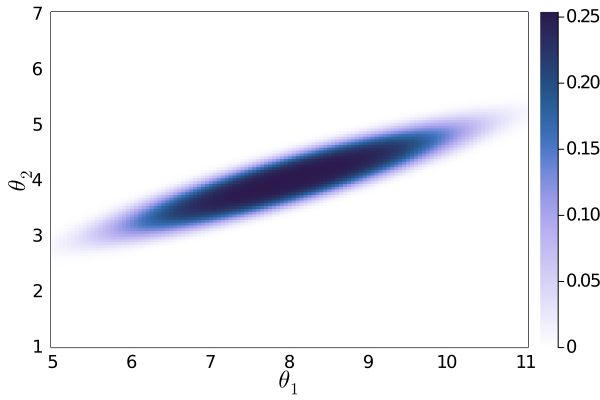

In [8]:
legendfontsize = 12
tickfontsize = 12
labelfontsize = 16

p = heatmap(5:0.05:11, 1:0.05:7,
    (x,y) -> fig3_unrestricted_posterior([x,y]),
    xlabel = "\$\\theta_1\$",
    ylabel = "\$\\theta_2\$",
    fill=true,
    levels = 100,
    framestyle = :box,
    yguidefontsize = labelfontsize, ytickfontsize = tickfontsize, legendfontsize = legendfontsize, 
    xguidefontsize = labelfontsize, xtickfontsize = tickfontsize,
    color = cgrad(:devon, rev = true))
plot(p)

In [9]:
function combine_and_reweight_particles(all_particles, all_weights, all_distances, num_proposals, epsilon_schedule; scale_by_ess = true, all_proposals = nothing)
    # taking all particles from earlier rounds that fit each round's tolerance
    keep_particles = []
    new_weights = []
    for i = 1:length(epsilon_schedule)
        keep_index = [d .< epsilon_schedule[i] for d in all_distances[1:(i)]]
        append!(keep_particles, [hcat([all_particles[j][:, keep_index[j]] for j = 1:(i)]...)])
        if scale_by_ess            
            kept_weights = [normalize(all_weights[j][keep_index[j]], 1) for j = 1:(i)]
            kept_weights = [w .* effective_sample_size(w) for w in kept_weights]
            append!(new_weights, [vcat(kept_weights...)])
        else
            # scaling by joint importance distribution, which works but is expensive
            prior = all_proposals[1]
            round_proposal = MixtureModel(all_proposals[1:i], normalize(num_proposals[1:i], 1))
            append!(new_weights, [[pdf(prior, keep_particles[i][:, j])/pdf(round_proposal, keep_particles[i][:, j])
                                    for j in 1:size(keep_particles[i],2)]])
        end
    end
    return keep_particles, new_weights
end

combine_and_reweight_particles (generic function with 1 method)

In [10]:
target_mean = Dict("function" => θ -> θ,
                    "true_expectation" => [8,4],
                    "categorical_function" => categorical_mean,
)
target_second_moment = Dict("function" => θ -> θ*θ',
                            "true_expectation" => [8,4]*[8,4]' + (2*pi)^(-1/2)*[5 2; 2 1],
                            "categorical_function" => categorical_second_moment,
)
target_variance = Dict("true_expectation" => (2*pi)^(-1/2)*[5 2; 2 1],
                            "categorical_function" => categorical_covariance,
)
target_functions = Dict("mean" => target_mean,
                        "variance" => target_variance,
                        "second_moment" => target_second_moment,
)

function squared_error(estimate, reference)
    return norm(vec(estimate - reference))^2
end

function error_statistics(;num_trials = 10,
        prior = fig3_prior,
        simulator = fig3_simulator,
        data = [0],
        target_function_key = "mean",
        target_function_data = target_functions,
        error_only_variance = false,
        target_acceptances = 800,
        epsilon_schedule = [160, 120, 80, 60, 40, 30, 20, 15, 10, 8, 6, 4, 3, 2, 1], # taken from Filippi et al. kernel optimality
        proposal_kernel = :local_MVNormal,
    )
    proposals = -1*ones(length(epsilon_schedule), num_trials)
    errors = -1*ones(length(epsilon_schedule), num_trials)
    effective_sample_sizes = -1*ones(length(epsilon_schedule), num_trials)
    keep_errors = -1*ones(length(epsilon_schedule), num_trials)
    keep_effective_sample_sizes = -1*ones(length(epsilon_schedule), num_trials)
    keep_total_accepted = -1*ones(length(epsilon_schedule), num_trials)

    estimate_means = []
    keep_estimate_means = []

    
    # running smc + estimating expectations
    for i = 1:num_trials
        all_particles, all_weights, all_distances, num_proposals = run_smc(prior = prior,
                                                        data = data,
                                                        simulator = simulator,
                                                        target_acceptances = target_acceptances,
                                                        epsilon_schedule = epsilon_schedule,
                                                        proposal_kernel = proposal_kernel,
        );
        append!(estimate_means, [target_function_data[target_function_key]["categorical_function"].(all_particles, all_weights)]) 
        
        proposals[:,i] = num_proposals
        effective_sample_sizes[:,i] = effective_sample_size.(all_weights)
        
        # if we kept all particles within threshold
        keep_particles, keep_weights = combine_and_reweight_particles(all_particles, all_weights, all_distances, num_proposals, epsilon_schedule)
        append!(keep_estimate_means, [target_function_data[target_function_key]["categorical_function"].(keep_particles, keep_weights)])
        
        keep_effective_sample_sizes[:,i] = effective_sample_size.(keep_weights)
        keep_total_accepted[:, i] = size.(keep_particles, 2)
    end
    
    if error_only_variance
        reference_expectations = mean(keep_estimate_means) # taking mean over outer layer (trials)
    else
        reference_expectations = [target_function_data[target_function_key]["true_expectation"] for i in 1:length(epsilon_schedule)]
    end
    
    # computing errors
    for i = 1:num_trials
        errors[:, i] = squared_error.(estimate_means[i], reference_expectations)
        keep_errors[:, i] = squared_error.(keep_estimate_means[i], reference_expectations)
    end
    
    error_data = Dict()
    error_data["proposals"] = proposals
    error_data["errors"] = errors
    error_data["final accepted"] = target_acceptances
    error_data["effective sample sizes"] = effective_sample_sizes
    error_data["keep errors"] = keep_errors
    error_data["keep effective sample sizes"] = keep_effective_sample_sizes
    error_data["keep total accepted"] = keep_total_accepted
    error_data["epsilon schedule"] = epsilon_schedule
    error_data["target function"] = target_function_key
    return error_data
end

error_statistics (generic function with 1 method)

In [11]:
num_trials = 100

100

In [12]:

@time local_MVN_error_data = error_statistics(num_trials = num_trials)

443.568707 seconds (4.02 G allocations: 359.023 GiB, 13.79% gc time)


Dict{Any,Any} with 9 entries:
  "errors"                      => [0.349963 0.291272 … 0.00165443 0.198671; 0.…
  "proposals"                   => [16066.0 16359.0 … 16491.0 15149.0; 1114.0 1…
  "keep errors"                 => [0.349963 0.291272 … 0.00165443 0.198671; 0.…
  "keep effective sample sizes" => [800.0 800.0 … 800.0 800.0; 1369.09 1373.46 …
  "effective sample sizes"      => [800.0 800.0 … 800.0 800.0; 763.09 757.464 ……
  "keep total accepted"         => [800.0 800.0 … 800.0 800.0; 1406.0 1416.0 … …
  "target function"             => "mean"
  "epsilon schedule"            => [160, 120, 80, 60, 40, 30, 20, 15, 10, 8, 6,…
  "final accepted"              => 800

In [13]:
println("ESSs: \n", mean(local_MVN_error_data["effective sample sizes"], dims = 2)')
println("Errors: \n", mean(local_MVN_error_data["errors"], dims = 2)')
println("Proposals per round: \n", mean(local_MVN_error_data["proposals"], dims = 2)')
println("Total proposals: \n",cumsum(mean(local_MVN_error_data["proposals"], dims = 2), dims = 1)')

ESSs: 
[800.0 762.8333846831307 761.5305624636177 760.9665754783512 762.6725253884247 760.7967955247008 762.0637108275404 760.5351737318139 761.668620255959 754.2676951366069 755.7314368209653 754.4997014187279 723.1239150277507 705.3015911223521 682.4525573520824]
Errors: 
[0.2756871327638059 0.23880373325246776 0.13947207098422276 0.13106750089517064 0.0856969666277012 0.0652034893842432 0.03782197642770057 0.031015516839607554 0.022312965777554067 0.013894186270655522 0.013492429250765216 0.010728415881125605 0.008944983984538822 0.006181236054028046 0.006193796805489005]
Proposals per round: 
[15971.12 1151.59 1277.44 1156.64 1293.17 1157.65 1293.18 1157.99 1286.45 1109.82 1176.26 1310.02 1242.09 1434.44 2116.92]
Total proposals: 
[15971.12 17122.71 18400.149999999998 19556.789999999997 20849.96 22007.61 23300.79 24458.780000000002 25745.230000000003 26855.050000000003 28031.31 29341.33 30583.420000000002 32017.86 34134.78]


### Using a uniform kernel

In [14]:
uniform_target_acceptances = 360
@time uniform_error_data = error_statistics(num_trials = num_trials, proposal_kernel = :uniform, target_acceptances = uniform_target_acceptances)

 30.083567 seconds (233.71 M allocations: 45.367 GiB, 22.59% gc time)


Dict{Any,Any} with 9 entries:
  "errors"                      => [0.799763 0.451848 … 0.411297 0.12601; 0.128…
  "proposals"                   => [6764.0 6932.0 … 7124.0 7160.0; 1561.0 1660.…
  "keep errors"                 => [0.799763 0.451848 … 0.411297 0.12601; 0.017…
  "keep effective sample sizes" => [360.0 360.0 … 360.0 360.0; 618.197 607.203 …
  "effective sample sizes"      => [360.0 360.0 … 360.0 360.0; 351.197 351.203 …
  "keep total accepted"         => [360.0 360.0 … 360.0 360.0; 627.0 616.0 … 62…
  "target function"             => "mean"
  "epsilon schedule"            => [160, 120, 80, 60, 40, 30, 20, 15, 10, 8, 6,…
  "final accepted"              => 360

In [15]:
println("ESSs: \n", mean(uniform_error_data["effective sample sizes"], dims = 2)')
println("Errors: \n", mean(uniform_error_data["errors"], dims = 2)')
println("Keep errors: \n", mean(uniform_error_data["keep errors"], dims = 2)')
println("Proposals per round: \n", mean(uniform_error_data["proposals"], dims = 2)')
println("Total proposals: \n",cumsum(mean(uniform_error_data["proposals"], dims = 2), dims = 1)')

ESSs: 
[360.0 350.39480567373874 351.74398975238097 350.407821908457 351.8971518869616 350.5186522944959 351.67353624158676 350.5179738641655 351.94535947678924 349.660506875242 350.48951322510345 352.09432932451836 350.9663155497486 351.9394565680834 353.0606307128518]
Errors: 
[0.6234075737064549 0.47311696882348175 0.42936861390372805 0.25819075836699534 0.19881673556672794 0.1445468378174329 0.09990161198983286 0.0850516413882067 0.051527523639558766 0.04135889168115758 0.03092756911576047 0.023118317702227182 0.020360801262366182 0.012459862140180555 0.007912129578840242]
Keep errors: 
[0.6234075737064545 0.2637525287688986 0.16311541385182474 0.09453786903692954 0.06645264348456456 0.04476451309171288 0.030232130602687337 0.029183343732401293 0.01429414622512962 0.00923229537641595 0.007722701130535046 0.005031739606482513 0.003819721525321159 0.003680530212206305 0.0023410211598613676]
Proposals per round: 
[7168.49 1629.1100000000001 1785.3500000000001 1642.78 1784.610000000000

### Comparing to pure rejection sampling from the prior

Here we expect sampling from the prior to do pretty badly because it is so diffuse.

In [16]:
rejection_target_acceptances = 11
rejection_error_data = error_statistics(num_trials = num_trials,epsilon_schedule = [1], target_acceptances = rejection_target_acceptances)


Dict{Any,Any} with 9 entries:
  "errors"                      => [0.747898 0.157806 … 0.79634 1.83283]
  "proposals"                   => [28184.0 32045.0 … 31455.0 29570.0]
  "keep errors"                 => [0.747898 0.157806 … 0.79634 1.83283]
  "keep effective sample sizes" => [11.0 11.0 … 11.0 11.0]
  "effective sample sizes"      => [11.0 11.0 … 11.0 11.0]
  "keep total accepted"         => [11.0 11.0 … 11.0 11.0]
  "target function"             => "mean"
  "epsilon schedule"            => [1]
  "final accepted"              => 11

In [17]:
println(mean(rejection_error_data["proposals"]))
println(mean(rejection_error_data["errors"]), std(rejection_error_data["errors"])/sqrt(num_trials))

35349.45
0.230459092489579130.03162353363203853


### Changing epsilon schedule


In [18]:
fast_decay_target_acceptances = 680
@time fast_decay_error_data = error_statistics(num_trials = num_trials, epsilon_schedule = [160, 8, 1], target_acceptances = fast_decay_target_acceptances)



 61.955598 seconds (455.59 M allocations: 86.196 GiB, 20.37% gc time)


Dict{Any,Any} with 9 entries:
  "errors"                      => [0.0673099 0.0119441 … 0.475799 0.926731; 0.…
  "proposals"                   => [12820.0 13889.0 … 13217.0 13553.0; 16537.0 …
  "keep errors"                 => [0.0673099 0.0119441 … 0.475799 0.926731; 0.…
  "keep effective sample sizes" => [680.0 680.0 … 680.0 680.0; 696.173 700.875 …
  "effective sample sizes"      => [680.0 680.0 … 680.0 680.0; 671.173 663.875 …
  "keep total accepted"         => [680.0 680.0 … 680.0 680.0; 705.0 717.0 … 72…
  "target function"             => "mean"
  "epsilon schedule"            => [160, 8, 1]
  "final accepted"              => 680

In [19]:
mean(fast_decay_error_data["proposals"], dims = 2)'

1×3 Adjoint{Float64,Array{Float64,2}}:
 13451.3  14707.4  5777.12

In [20]:
sum(mean(fast_decay_error_data["proposals"], dims = 2)')

33935.86

In [21]:
mean(fast_decay_error_data["errors"], dims = 2)

3×1 Array{Float64,2}:
 0.4093724889670373  
 0.01992174724634775 
 0.004398890025326914

In [22]:
std(fast_decay_error_data["errors"], dims = 2)/sqrt(num_trials)

3×1 Array{Float64,2}:
 0.045542424145757314 
 0.0026254015273655586
 0.000522889200943905 

# Data plots


## Plots as function of threshold

In [23]:
error_datas = [local_MVN_error_data, uniform_error_data, fast_decay_error_data, rejection_error_data]
method_labels = ["Local MVN", "Uniform", "Fast decay", "Rejection"]
method_colors = [1,2,3,4];

legendfontsize = 12
tickfontsize = 12
labelfontsize = 16

16

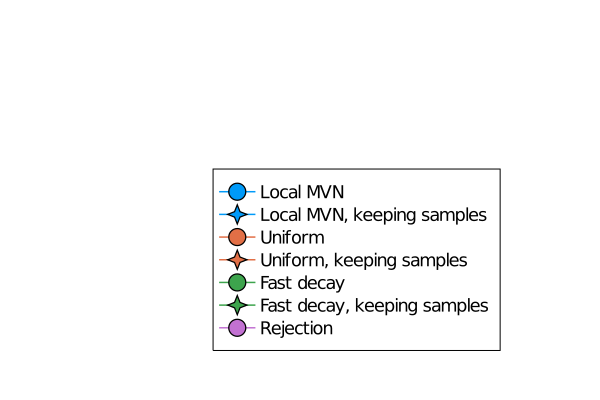

In [24]:
# plotting legend separately rather than repeating across plots and obscuring them
legend_plot = scatter([1], [1],
            m = (6),
            label = nothing,
            legend = (0.4, 0.5),
            framestyle = :none,
            xlim = [0.9, 1.1],
            ylim = [0.9, 1.1],
            legendfontsize = 12,
        )

for (edata,label, color) in zip(error_datas, method_labels, method_colors)
    plot!([1], [1],
        c = color,
            m = (6, :circle),
            label =label)
    if !(label == "Rejection")
        plot!([1], [1], c= color, m = (6, :star4), label = label*", keeping samples")
    end
end
plot(legend_plot)


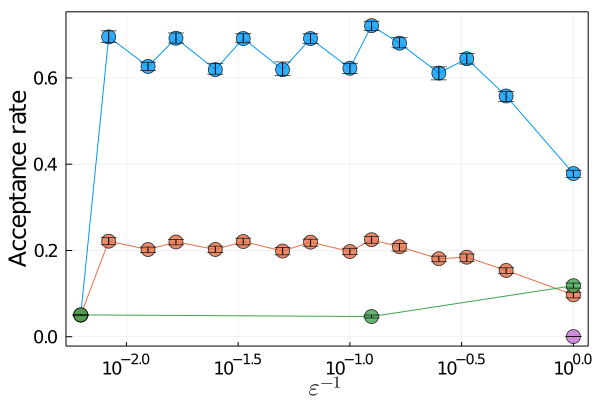

In [25]:

function plot_score!(scores, epsilons; name = "Performance score", label = nothing, yscale = :identity, legend = :left, marker = (8, 0.8), color = :auto)
    mean_scores = vec(mean(scores, dims = 2))
    
    bottom_error_bar = [quantile(scores[i,:], 0.25) for i in 1:size(scores, 1)]
    top_error_bar = [quantile(scores[i,:], 0.75) for i in 1:size(scores, 1)]
    plot!(1 ./(epsilons),
        mean_scores,
        yerr = (mean_scores - bottom_error_bar, top_error_bar - mean_scores),
        label = label,
        xlabel = "\$\\epsilon^{-1}\$",
        ylabel = name,
        legend = legend,
        xscale = :log10,
        yscale = yscale,
        framestyle = :box,
        color = color,
        yguidefontsize = labelfontsize, ytickfontsize = tickfontsize, legendfontsize = legendfontsize, 
        xguidefontsize = labelfontsize, xtickfontsize = tickfontsize,
        m = marker
        )
end
function plot_score(scores, epsilons; name = "Performance score", label = nothing, marker = (5, 0.8), color = :auto)
    plot()
    plot_score!(scores, epsilons, name = name, label = label, marker = marker, color = color)
end


function plot_scores_vs_epsilons(error_datas,key, name; method_labels = method_labels, method_colors = method_colors, plot_keep = true, yscale = :log10, legend = :best)
    for (edata,label, color) in zip(error_datas, method_labels, method_colors)
        plot_score!(edata[key], 
            edata["epsilon schedule"] .* (1 + 0.02*color), 
            label = label,
            name = name,
            yscale = yscale,
            legend = legend,
            color = color,
        )
        if plot_keep & (label != "Rejection")
            plot_score!(edata["keep "*key] .* (1 - 0.02*color),
                edata["epsilon schedule"], 
                label = label*", keeping samples", 
                color = color,
                marker = (7, 0.8, :star4)
            )
        end
    end
end
p = plot()
for (edata,label) in zip(error_datas, method_labels)
    plot_score!(edata["final accepted"]./edata["proposals"], 
        edata["epsilon schedule"], 
        label = label,
        name = "Acceptance rate",
        legend = nothing,
    )
end

plot(p)

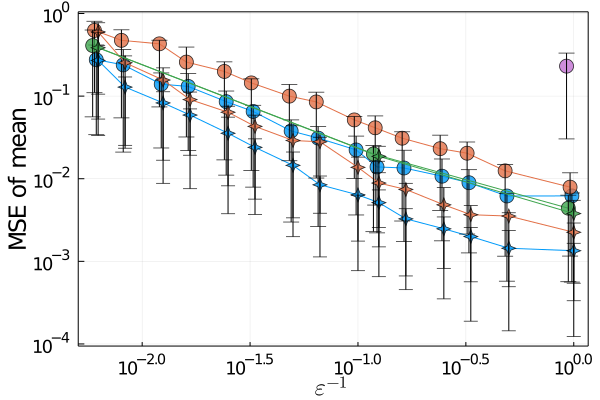

In [26]:
p = plot()

plot_scores_vs_epsilons(error_datas, "errors", "MSE of mean", legend = nothing)

plot(p)


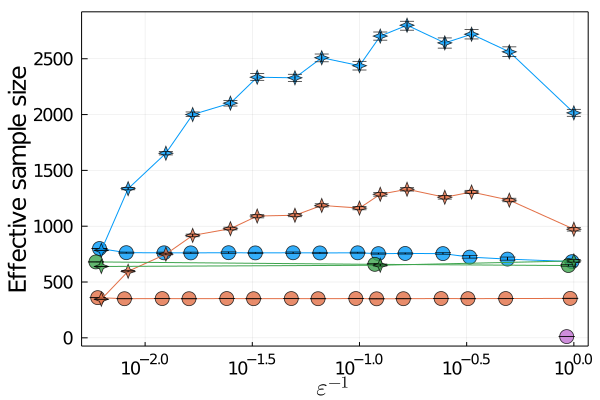

In [27]:
p = plot()

plot_scores_vs_epsilons(error_datas,
    "effective sample sizes",
    "Effective sample size",
    yscale = :identity,
    legend = nothing)

plot(p)


## Plots comparing scores

In [28]:
function mean_and_quantiles(v, q1 = 0.25, q2 = 0.75)
    μ = mean(v)
    return [μ, quantile(vec(v), 0.25), quantile(vec(v), 0.75)]
end
function reformat_errors(v)
    return [v[1], v[1] - minimum(v[2:end]), maximum(v[2:end]) - v[1]]
end

reformat_errors (generic function with 1 method)

In [29]:
function compute_scores(error_data)
    return Dict("Final Effective sample size" => reformat_errors(mean_and_quantiles(error_data["effective sample sizes"][end, :])),
        "Final Acceptance rate" => reformat_errors(mean_and_quantiles(error_data["final accepted"]./sum(error_data["proposals"], dims = 1))), # total, not per round
        "Final Precision" => reformat_errors(1 ./mean_and_quantiles(error_data["errors"][end, :])),
        "Keep all Effective sample size" => reformat_errors(mean_and_quantiles(error_data["keep effective sample sizes"][end, :])),
        "Keep all Acceptance rate" => reformat_errors(mean_and_quantiles(error_data["keep total accepted"]./sum(error_data["proposals"], dims = 1))), # total, not per round
        "Keep all Precision" => reformat_errors(1 ./mean_and_quantiles(error_data["keep errors"][end, :]))
    )
end

compute_scores (generic function with 1 method)

In [30]:
local_MVN_final_scores = compute_scores(local_MVN_error_data)
uniform_final_scores = compute_scores(uniform_error_data)
rejection_final_scores = compute_scores(rejection_error_data)
fast_decay_final_scores = compute_scores(fast_decay_error_data)


all_final_scores = Dict("Local MVN" => local_MVN_final_scores,
        "Uniform" => uniform_final_scores,
        "Rejection sampling" => rejection_final_scores,
        "Faster threshold decrease"=> fast_decay_final_scores,
)

Dict{String,Dict{String,Array{Float64,1}}} with 4 entries:
  "Local MVN"                 => Dict("Final Acceptance rate"=>[0.0234418, 0.00…
  "Uniform"                   => Dict("Final Acceptance rate"=>[0.0104887, 0.00…
  "Faster threshold decrease" => Dict("Final Acceptance rate"=>[0.0200921, 0.00…
  "Rejection sampling"        => Dict("Final Acceptance rate"=>[0.000334477, 6.…

Local MVN: 37.20804858908901, 70.08499285575881, [2.9281067810608556, 373.56686993824707]
Local MVN: 167.9535532313753, 206.07102243232498, [31.35764284743276, 1671.8635667618378]
Uniform: 29.127315243408813, 31.35866812540036, [9.593929148962127, 169.91009831330936]
Uniform: 98.44383145311966, 95.089467737391, [22.40736155608731, 564.6398402353846]
Faster threshold decrease: 52.39028281286754, 60.07030780586669, [15.931091751658816, 354.0351571084478]
Faster threshold decrease: 57.18865842980837, 63.630283285326314, [17.640267031352188, 341.5699401089647]
Rejection sampling: 1.0, 1.0, [0.30512620078596014, 6.596067957655579]


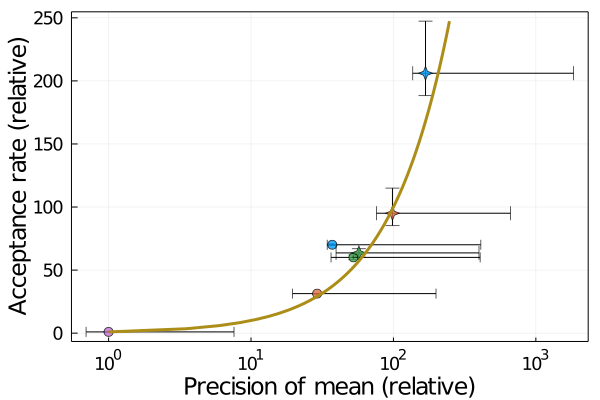

In [31]:
function plot_score_comparison(all_scores, y_score = "Acceptance rate"; x_score = "Precision", target_f = "", reference_label = nothing, legend = :best, xscale = :log10)
    p = plot()
    max_x = 0
    max_y = 0
    if reference_label == nothing
        label_adjustment = ""
    else
        label_adjustment = " (relative)"
    end
    if x_score == "Precision"
        xlabel_adjustment = " of "*target_f
    else
        xlabel_adjustment = ""
    end
    for (label, color) in zip(keys(all_scores), 1:length(keys(all_scores)))
        for (prefix, marker) in zip(["Final ", "Keep all "], ((5, 0.8, :circle), (7, 0.8,:star4)))
            if prefix*label == "Keep all Rejection sampling"
                # keep all makes no difference for rejection sampling
                continue
            end
            x = all_scores[label][prefix*x_score][1]
            y = all_scores[label][prefix*y_score][1]
            xerr = all_scores[label][prefix*x_score][2:end]
            yerr = all_scores[label][prefix*y_score][2:end]
            if !(reference_label == nothing)
                x_scale = all_scores[reference_label]["Final "*x_score][1]
                y_scale = all_scores[reference_label]["Final "*y_score][1]
                x = x/x_scale
                y = y/y_scale
            
                xerr = xerr/x_scale
                yerr = yerr/y_scale
                max_x = maximum([x, x+xerr[2], max_x])
                max_y = maximum([y, y+yerr[2], max_y])
            end
            println(label, ": ", x, ", ", y, ", ", xerr)
            scatter!([x],
                [y],
                label = label*", "*lowercase(prefix[1:(end-1)]),
                xlabel = x_score*xlabel_adjustment*label_adjustment,
                ylabel = y_score*label_adjustment,
                xerr = ([xerr[1]], [xerr[2]]),
                yerr = ([yerr[1]], [yerr[2]]),
                framestyle = :box,
                legend = legend,
                xscale = xscale,
                color = color,
                m = marker,
                yguidefontsize = labelfontsize, ytickfontsize = tickfontsize, legendfontsize = legendfontsize, 
                xguidefontsize = labelfontsize, xtickfontsize = tickfontsize,
            )
        end
    end
    if !(reference_label == nothing)
        minmax = min(max_x, max_y)
        plot!(range(1,stop=minmax, length=100), range(1,stop=minmax, length=100), label = nothing, linewidth = 3, color = 1 + length(all_scores))
    end
    return p
end

p = plot_score_comparison(all_final_scores, reference_label = "Rejection sampling", target_f = "mean", legend = nothing)

plot(p)


Local MVN: 37.20804858908901, 62.041141577462035, [2.9281067810608556, 373.56686993824707]
Local MVN: 167.9535532313753, 186.93052511005516, [31.35764284743276, 1671.8635667618378]
Uniform: 29.127315243408813, 32.09642097389562, [9.593929148962127, 169.91009831330936]
Uniform: 98.44383145311966, 92.14096437083298, [22.40736155608731, 564.6398402353846]
Faster threshold decrease: 52.39028281286754, 58.87965466617948, [15.931091751658816, 354.0351571084478]
Faster threshold decrease: 57.18865842980837, 66.63171128521873, [17.640267031352188, 341.5699401089647]
Rejection sampling: 1.0, 1.0, [0.30512620078596014, 6.596067957655579]


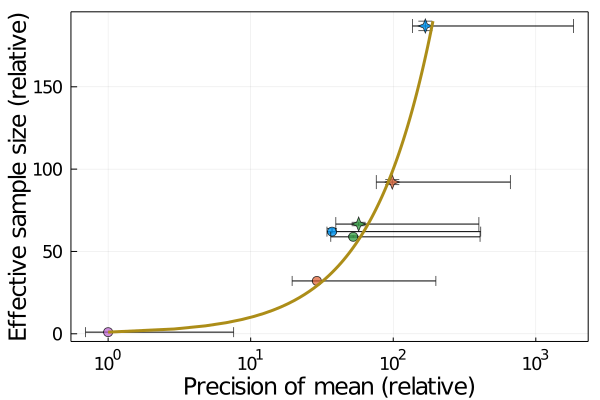

In [32]:
p = plot_score_comparison(all_final_scores, "Effective sample size", reference_label = "Rejection sampling", target_f = "mean", legend = nothing)
plot(p)

## Estimating variance

In [33]:

@time local_MVN_variance_error_data = error_statistics(num_trials = num_trials, target_function_key = "variance")



422.943276 seconds (4.03 G allocations: 360.862 GiB, 14.11% gc time)


Dict{Any,Any} with 9 entries:
  "errors"                      => [45634.9 49744.3 … 50492.9 55370.1; 29428.5 …
  "proposals"                   => [15314.0 16156.0 … 15534.0 14803.0; 1126.0 1…
  "keep errors"                 => [45634.9 49744.3 … 50492.9 55370.1; 27411.9 …
  "keep effective sample sizes" => [800.0 800.0 … 800.0 800.0; 1387.21 1356.8 ……
  "effective sample sizes"      => [800.0 800.0 … 800.0 800.0; 767.212 767.799 …
  "keep total accepted"         => [800.0 800.0 … 800.0 800.0; 1420.0 1389.0 … …
  "target function"             => "variance"
  "epsilon schedule"            => [160, 120, 80, 60, 40, 30, 20, 15, 10, 8, 6,…
  "final accepted"              => 800

In [34]:
@time uniform_variance_error_data = error_statistics(num_trials = num_trials,
    target_function_key = "variance",
    target_acceptances = uniform_target_acceptances,
    proposal_kernel = :uniform,
)

 31.095850 seconds (246.33 M allocations: 46.364 GiB, 23.11% gc time)


Dict{Any,Any} with 9 entries:
  "errors"                      => [56979.3 51081.4 … 50457.2 59715.9; 27954.4 …
  "proposals"                   => [7271.0 7248.0 … 6382.0 7773.0; 1582.0 1442.…
  "keep errors"                 => [56979.3 51081.4 … 50457.2 59715.9; 30951.7 …
  "keep effective sample sizes" => [360.0 360.0 … 360.0 360.0; 623.882 637.912 …
  "effective sample sizes"      => [360.0 360.0 … 360.0 360.0; 350.882 349.912 …
  "keep total accepted"         => [360.0 360.0 … 360.0 360.0; 633.0 648.0 … 62…
  "target function"             => "variance"
  "epsilon schedule"            => [160, 120, 80, 60, 40, 30, 20, 15, 10, 8, 6,…
  "final accepted"              => 360

In [35]:
@time fast_decay_variance_error_data = error_statistics(num_trials = num_trials,
    epsilon_schedule = [160, 8, 1],
    target_acceptances = fast_decay_target_acceptances,
    target_function_key = "variance",
)

 62.349038 seconds (457.90 M allocations: 85.997 GiB, 20.91% gc time)


Dict{Any,Any} with 9 entries:
  "errors"                      => [53129.4 52593.9 … 59732.7 46060.8; 93.85 82…
  "proposals"                   => [13538.0 13970.0 … 13179.0 13272.0; 15134.0 …
  "keep errors"                 => [53129.4 52593.9 … 59732.7 46060.8; 93.497 8…
  "keep effective sample sizes" => [680.0 680.0 … 680.0 680.0; 702.341 697.814 …
  "effective sample sizes"      => [680.0 680.0 … 680.0 680.0; 673.341 664.814 …
  "keep total accepted"         => [680.0 680.0 … 680.0 680.0; 709.0 713.0 … 70…
  "target function"             => "variance"
  "epsilon schedule"            => [160, 8, 1]
  "final accepted"              => 680

In [36]:
@time rejection_variance_error_data = error_statistics(num_trials = num_trials,
    epsilon_schedule = [1],
    target_acceptances = rejection_target_acceptances,
    target_function_key = "variance",
)

  1.264239 seconds (21.77 M allocations: 1.190 GiB, 11.11% gc time)


Dict{Any,Any} with 9 entries:
  "errors"                      => [2.82416 0.14695 … 0.963995 0.0679054]
  "proposals"                   => [37437.0 21285.0 … 36992.0 31396.0]
  "keep errors"                 => [2.82416 0.14695 … 0.963995 0.0679054]
  "keep effective sample sizes" => [11.0 11.0 … 11.0 11.0]
  "effective sample sizes"      => [11.0 11.0 … 11.0 11.0]
  "keep total accepted"         => [11.0 11.0 … 11.0 11.0]
  "target function"             => "variance"
  "epsilon schedule"            => [1]
  "final accepted"              => 11

In [37]:
variance_error_datas = [local_MVN_variance_error_data,
    uniform_variance_error_data,
    fast_decay_variance_error_data,
    rejection_variance_error_data];

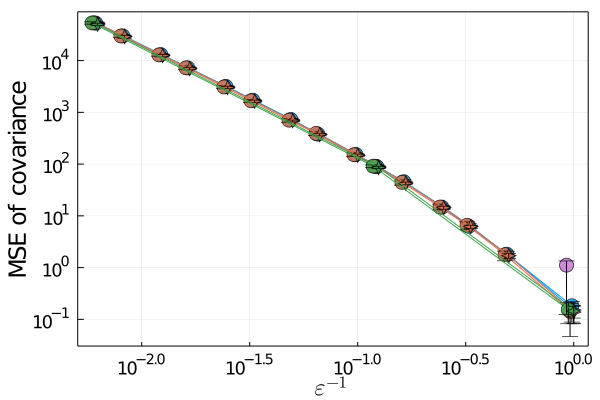

In [38]:
p = plot()

plot_scores_vs_epsilons(variance_error_datas, "errors", "MSE of covariance", legend = nothing)
plot(p)

In [39]:
local_MVN_variance_scores = compute_scores(local_MVN_variance_error_data)
uniform_variance_scores = compute_scores(uniform_variance_error_data)
rejection_variance_scores = compute_scores(rejection_variance_error_data)
fast_decay_variance_scores = compute_scores(fast_decay_variance_error_data)


all_variance_scores = Dict("Local MVN" => local_MVN_variance_scores,
        "Uniform" => uniform_variance_scores,
        "Rejection sampling" => rejection_variance_scores,
        "Faster threshold decrease"=> fast_decay_variance_scores,
)

Dict{String,Dict{String,Array{Float64,1}}} with 4 entries:
  "Local MVN"                 => Dict("Final Acceptance rate"=>[0.0234934, 0.00…
  "Uniform"                   => Dict("Final Acceptance rate"=>[0.0105379, 0.00…
  "Faster threshold decrease" => Dict("Final Acceptance rate"=>[0.0201305, 0.00…
  "Rejection sampling"        => Dict("Final Acceptance rate"=>[0.000327866, 6.…

Local MVN: 6.0821411557549245, 71.65535317720874, [1.0739024757597015, 6.49936890840399]
Local MVN: 7.1351374725209835, 210.6156927623408, [1.3067540285269263, 3.1622101759881405]
Uniform: 7.76607378217012, 32.140941938648304, [2.2736381524087386, 16.212324882608023]
Uniform: 7.781589342723897, 97.70260919072965, [2.0264211722347456, 4.999623944977875]
Faster threshold decrease: 7.221035568852784, 61.39836984584888, [1.984879738782028, 6.264930908493983]
Faster threshold decrease: 7.231989978859064, 65.06010982513082, [1.3385257962328214, 5.502968726701712]
Rejection sampling: 1.0, 1.0, [0.1726964757592095, 7.9281193519816915]


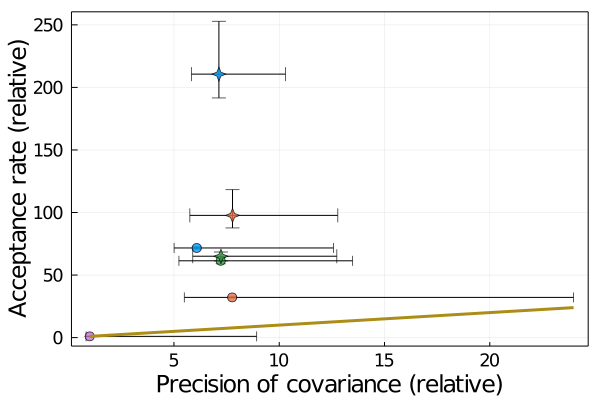

In [40]:
p = plot_score_comparison(all_variance_scores,
    reference_label = "Rejection sampling",
    legend = nothing,
    target_f = "covariance",
    xscale = :identity)
plot(p)

Local MVN: 6.0821411557549245, 61.22868928634402, [1.0739024757597015, 6.49936890840399]
Local MVN: 7.1351374725209835, 185.6096420305555, [1.3067540285269263, 3.1622101759881405]
Uniform: 7.76607378217012, 32.107440334527496, [2.2736381524087386, 16.212324882608023]
Uniform: 7.781589342723897, 92.22505769578488, [2.0264211722347456, 4.999623944977875]
Faster threshold decrease: 7.221035568852784, 59.459047457608214, [1.984879738782028, 6.264930908493983]
Faster threshold decrease: 7.231989978859064, 67.24422471455263, [1.3385257962328214, 5.502968726701712]
Rejection sampling: 1.0, 1.0, [0.1726964757592095, 7.9281193519816915]


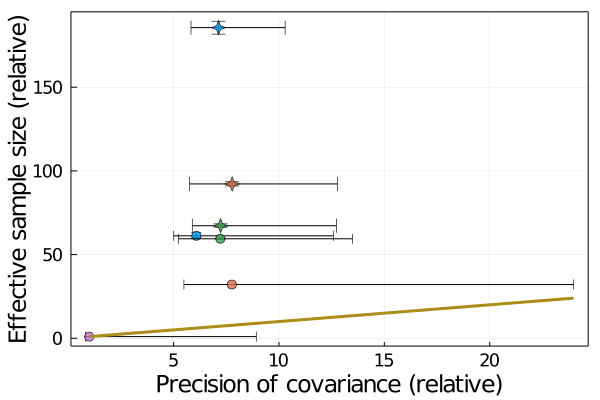

In [41]:
p = plot_score_comparison(all_variance_scores, "Effective sample size", reference_label = "Rejection sampling", legend = nothing, target_f = "covariance", xscale = :identity)

plot(p)

### Estimating ABC variance


In [42]:

@time local_MVN_ABC_variance_error_data = error_statistics(num_trials = num_trials,
    target_function_key = "variance",
    error_only_variance = true)



426.540253 seconds (4.03 G allocations: 360.812 GiB, 14.00% gc time)


Dict{Any,Any} with 9 entries:
  "errors"                      => [70.8112 50.5325 … 72.6442 20.7819; 22.6505 …
  "proposals"                   => [15780.0 15778.0 … 16360.0 15580.0; 1142.0 1…
  "keep errors"                 => [70.8112 50.5325 … 72.6442 20.7819; 0.703008…
  "keep effective sample sizes" => [800.0 800.0 … 800.0 800.0; 1379.65 1367.8 ……
  "effective sample sizes"      => [800.0 800.0 … 800.0 800.0; 768.647 767.798 …
  "keep total accepted"         => [800.0 800.0 … 800.0 800.0; 1411.0 1400.0 … …
  "target function"             => "variance"
  "epsilon schedule"            => [160, 120, 80, 60, 40, 30, 20, 15, 10, 8, 6,…
  "final accepted"              => 800

In [43]:
@time uniform_ABC_variance_error_data = error_statistics(num_trials = num_trials,
    target_function_key = "variance",
    target_acceptances = uniform_target_acceptances,
    proposal_kernel = :uniform,
    error_only_variance = true,
)

 31.667496 seconds (246.37 M allocations: 46.368 GiB, 21.78% gc time)


Dict{Any,Any} with 9 entries:
  "errors"                      => [11.8863 132.885 … 24.1359 437.823; 47.3768 …
  "proposals"                   => [7359.0 7295.0 … 7507.0 7074.0; 1626.0 1549.…
  "keep errors"                 => [11.8863 132.885 … 24.1359 437.823; 6.86243 …
  "keep effective sample sizes" => [360.0 360.0 … 360.0 360.0; 618.086 630.259 …
  "effective sample sizes"      => [360.0 360.0 … 360.0 360.0; 351.086 351.259 …
  "keep total accepted"         => [360.0 360.0 … 360.0 360.0; 627.0 639.0 … 63…
  "target function"             => "variance"
  "epsilon schedule"            => [160, 120, 80, 60, 40, 30, 20, 15, 10, 8, 6,…
  "final accepted"              => 360

In [44]:
@time fast_decay_ABC_variance_error_data = error_statistics(num_trials = num_trials,
    epsilon_schedule = [160, 8, 1],
    target_acceptances = fast_decay_target_acceptances,
    target_function_key = "variance",
    error_only_variance = true,
)

 63.431641 seconds (458.19 M allocations: 86.608 GiB, 21.21% gc time)


Dict{Any,Any} with 9 entries:
  "errors"                      => [13.5992 549.432 … 8.41986 144.903; 0.354764…
  "proposals"                   => [12565.0 13534.0 … 13285.0 13242.0; 14308.0 …
  "keep errors"                 => [13.5992 549.432 … 8.41986 144.903; 0.310929…
  "keep effective sample sizes" => [680.0 680.0 … 680.0 680.0; 703.485 688.199 …
  "effective sample sizes"      => [680.0 680.0 … 680.0 680.0; 666.485 662.199 …
  "keep total accepted"         => [680.0 680.0 … 680.0 680.0; 717.0 706.0 … 71…
  "target function"             => "variance"
  "epsilon schedule"            => [160, 8, 1]
  "final accepted"              => 680

In [45]:
@time rejection_ABC_variance_error_data = error_statistics(num_trials = num_trials,
    epsilon_schedule = [1],
    target_acceptances = rejection_target_acceptances,
    target_function_key = "variance",
    error_only_variance = true,
)

  1.495408 seconds (21.09 M allocations: 1.153 GiB, 11.58% gc time)


Dict{Any,Any} with 9 entries:
  "errors"                      => [0.207867 0.355499 … 0.29278 0.369158]
  "proposals"                   => [27810.0 31211.0 … 21987.0 28490.0]
  "keep errors"                 => [0.207867 0.355499 … 0.29278 0.369158]
  "keep effective sample sizes" => [11.0 11.0 … 11.0 11.0]
  "effective sample sizes"      => [11.0 11.0 … 11.0 11.0]
  "keep total accepted"         => [11.0 11.0 … 11.0 11.0]
  "target function"             => "variance"
  "epsilon schedule"            => [1]
  "final accepted"              => 11

In [46]:
ABC_variance_error_datas = [local_MVN_ABC_variance_error_data,
    uniform_ABC_variance_error_data,
    fast_decay_ABC_variance_error_data,
    rejection_ABC_variance_error_data];

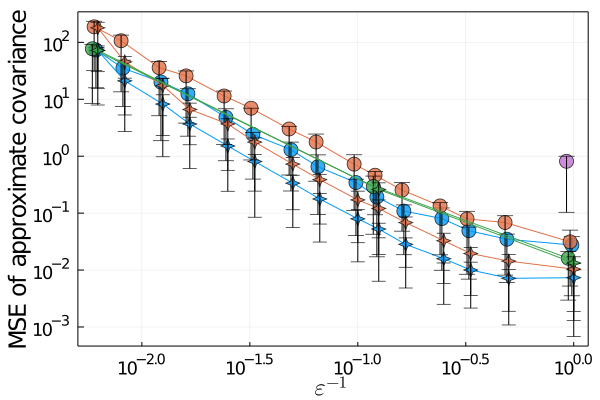

In [47]:
p = plot()

plot_scores_vs_epsilons(ABC_variance_error_datas, "errors", "MSE of approximate covariance", legend =  nothing)

plot(p)

In [48]:
local_MVN_ABC_variance_scores = compute_scores(local_MVN_ABC_variance_error_data)
uniform_ABC_variance_scores = compute_scores(uniform_ABC_variance_error_data)
rejection_ABC_variance_scores = compute_scores(rejection_ABC_variance_error_data)
fast_decay_ABC_variance_scores = compute_scores(fast_decay_ABC_variance_error_data)


all_ABC_variance_scores = Dict("Local MVN" => local_MVN_ABC_variance_scores,
        "Uniform"=> uniform_ABC_variance_scores,
        "Rejection sampling" => rejection_ABC_variance_scores,
        "Faster threshold decrease"=> fast_decay_ABC_variance_scores,
)

Dict{String,Dict{String,Array{Float64,1}}} with 4 entries:
  "Local MVN"                 => Dict("Final Acceptance rate"=>[0.0235319, 0.00…
  "Uniform"                   => Dict("Final Acceptance rate"=>[0.0105197, 0.00…
  "Faster threshold decrease" => Dict("Final Acceptance rate"=>[0.0200423, 0.00…
  "Rejection sampling"        => Dict("Final Acceptance rate"=>[0.000343083, 7.…

Local MVN: 29.60172087792227, 68.58962798022462, [8.53426248876582, 200.78132369976532]
Local MVN: 108.56222528644537, 201.27420062652274, [29.50978893840192, 1068.945548470795]
Uniform: 25.97716502926481, 30.66218247047448, [9.788431674560922, 129.55871411274023]
Uniform: 75.36967609401015, 93.19317156730902, [15.023284444370972, 528.9164311462739]
Faster threshold decrease: 50.59098706501097, 58.41816147443079, [12.384454675221557, 223.98192326823371]
Faster threshold decrease: 57.559683992910976, 61.877277196082034, [12.81241026887884, 351.3666949874693]
Rejection sampling: 1.0, 1.0, [0.18557411330449647, 6.878471412788043]


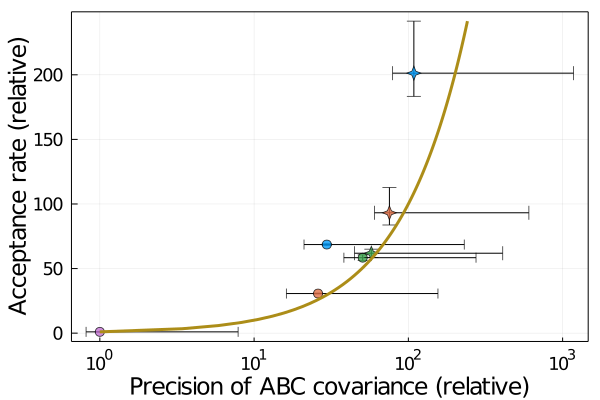

In [49]:
p = plot_score_comparison(all_ABC_variance_scores,
    reference_label = "Rejection sampling",
    legend = nothing,
    target_f = "ABC covariance",
    xscale = :log10)
plot(p)

Local MVN: 29.60172087792227, 61.329625401080314, [8.53426248876582, 200.78132369976532]
Local MVN: 108.56222528644537, 185.98699239095464, [29.50978893840192, 1068.945548470795]
Uniform: 25.97716502926481, 32.097148777609334, [9.788431674560922, 129.55871411274023]
Uniform: 75.36967609401015, 92.36311955127722, [15.023284444370972, 528.9164311462739]
Faster threshold decrease: 50.59098706501097, 59.159777610182545, [12.384454675221557, 223.98192326823371]
Faster threshold decrease: 57.559683992910976, 66.93878839261403, [12.81241026887884, 351.3666949874693]
Rejection sampling: 1.0, 1.0, [0.18557411330449647, 6.878471412788043]


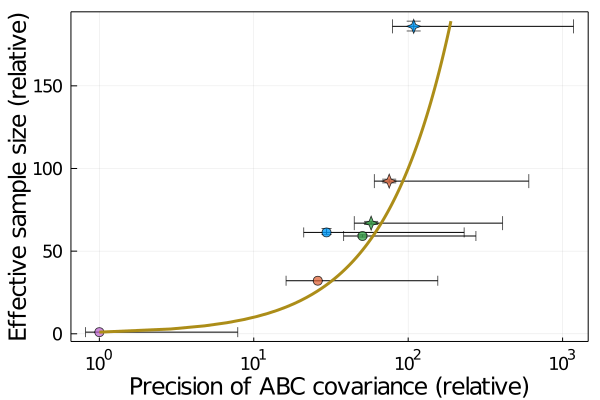

In [50]:
p = plot_score_comparison(all_ABC_variance_scores,
    "Effective sample size",
    reference_label = "Rejection sampling",
    legend = nothing,
    target_f = "ABC covariance",
    xscale = :log10)
plot(p)

# Checking sample sizes

In [51]:
[(m, mean(sum(edata["proposals"], dims = 1))) for (m, edata) in zip(method_labels, error_datas)]

4-element Array{Tuple{String,Float64},1}:
 ("Local MVN", 34134.78) 
 ("Uniform", 34334.77)   
 ("Fast decay", 33935.86)
 ("Rejection", 35349.45) 

In [52]:
[(m, mean(sum(edata["proposals"], dims = 1))) for (m, edata) in zip(method_labels, variance_error_datas)]

4-element Array{Tuple{String,Float64},1}:
 ("Local MVN", 34063.94)
 ("Uniform", 34174.74)  
 ("Fast decay", 33906.5)
 ("Rejection", 36231.66)

In [53]:
[(m, mean(sum(edata["proposals"], dims = 1))) for (m, edata) in zip(method_labels, ABC_variance_error_datas)]

4-element Array{Tuple{String,Float64},1}:
 ("Local MVN", 34003.38) 
 ("Uniform", 34230.17)   
 ("Fast decay", 34039.61)
 ("Rejection", 35101.8)  